# FITE3010 Group Project
Submitted by: Aatmiya Silwal (3036056897), Keith Chan (3035832141)

#### TMDB Box Office Prediction:
* Description: In this competition, you're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall
worldwide box office revenue.
* Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries.
* You can also collect other public data to make the prediction.

##### Step 1: Download the data through the API

`! pip install kaggle`  
`! kaggle competitions download -c tmdb-box-office-prediction`

For this, we need to ensure that the necessary requirements are setup accordingly. More information [here](https://github.com/Kaggle/kaggle-api).

##### Step 2: EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_predict, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb


train =pd.read_csv('data/train.csv')
test = pd.read_csv("data/test.csv")

In [2]:
#Additional data added from other external datasets
trainAdditionalFeatures = pd.read_csv('data/train_extra.csv')
testAdditionalFeatures = pd.read_csv('data/test_extra.csv')

train = pd.merge(train, trainAdditionalFeatures, how='left', on=['imdb_id'])
test = pd.merge(test, testAdditionalFeatures, how='left', on=['imdb_id'])

In [3]:
print("Shape of training data:", train.shape)
print("Shape of testing data:", test.shape)

Shape of training data: (3000, 26)
Shape of testing data: (4398, 25)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [5]:
train.describe()

,id,budget,popularity,runtime,revenue,popularity2,rating,totalVotes
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03,2882.000000,2882.000000,2882.000000
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07,8.029303,6.366308,933.938584
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08,4.959153,0.887465,1795.101380
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00,0.600000,1.000000,1.000000
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06,5.046250,5.800000,82.000000
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07,7.503500,6.400000,292.500000
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07,9.987000,7.000000,900.500000
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09,45.153000,9.000000,18931.000000


In [6]:
test.describe()

,id,budget,popularity,runtime,popularity2,rating,totalVotes
count,4398.000000,4.398000e+03,4398.000000,4394.000000,4219.000000,4219.000000,4219.000000
mean,5199.500000,2.264929e+07,8.550230,107.622212,8.159577,6.373880,973.764873
std,1269.737571,3.689991e+07,12.209014,21.058290,5.062191,0.912731,1839.158863
min,3001.000000,0.000000e+00,0.000001,0.000000,0.600000,0.000000,0.000000
25%,4100.250000,0.000000e+00,3.895186,94.000000,4.838000,5.800000,76.000000
50%,5199.500000,7.450000e+06,7.482242,104.000000,7.476000,6.400000,287.000000
75%,6298.750000,2.800000e+07,10.938524,118.000000,10.316000,7.000000,957.000000
max,7398.000000,2.600000e+08,547.488298,320.000000,47.787000,9.100000,20851.000000


In [7]:
train.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
popularity2               118
rating                    118
totalVotes                118
dtype: int64

In [8]:
test.isnull().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
popularity2               179
rating                    179
totalVotes                179
dtype: int64

In [9]:
#majority are null for these columns, so we remove these columns
train.drop(['belongs_to_collection'], axis=1, inplace=True)
test.drop(['belongs_to_collection'], axis=1, inplace=True)

#irrelevant to our purpose
train.drop(['imdb_id'], axis=1, inplace=True)
test.drop(['imdb_id'], axis=1, inplace=True)

train.drop(['poster_path'], axis=1, inplace=True)
test.drop(['poster_path'], axis=1, inplace=True)

#original language information already present
train.drop(['spoken_languages'], axis=1, inplace=True)
test.drop(['spoken_languages'], axis=1, inplace=True)

#original title and title are considered redundant
train.drop(['original_title'], axis=1, inplace=True)
test.drop(['original_title'], axis=1, inplace=True)


#whether a movie is released or not does not matter
train.drop(['status'], axis=1, inplace=True)
test.drop(['status'], axis=1, inplace=True)

#we assume release data and keywords do not make a different
train.drop(['tagline'], axis=1, inplace=True)
test.drop(['tagline'], axis=1, inplace=True)

train.drop(['Keywords'], axis=1, inplace=True)
test.drop(['Keywords'], axis=1, inplace=True)

In [10]:
train['has_homepage'] = train['homepage'].apply(lambda x: 1 if pd.notnull(x) and x != '' else 0)
test['has_homepage'] = test['homepage'].apply(lambda x: 1 if pd.notnull(x) and x != '' else 0)

train.drop(['homepage'], axis=1, inplace=True)
test.drop(['homepage'], axis=1, inplace=True)

In [11]:
train['has_overview'] = train['overview'].apply(lambda x: 1 if pd.notnull(x) and x != '' else 0)
test['has_overview'] = test['overview'].apply(lambda x: 1 if pd.notnull(x) and x != '' else 0)

train.drop(['overview'], axis=1, inplace=True)
test.drop(['overview'], axis=1, inplace=True)

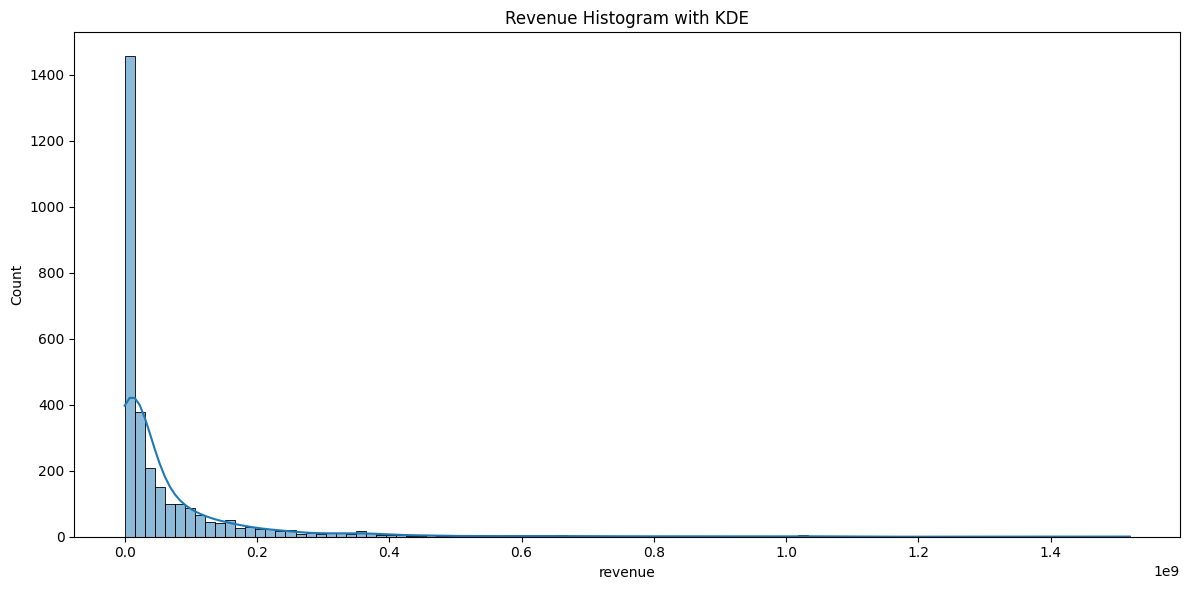

In [12]:
#revenue distrbution visualization
f, ax = plt.subplots(1, figsize=(12,6))

sns.histplot(train.revenue, kde=True, bins=100)  
ax.set_title("Revenue Histogram with KDE")
f.tight_layout()

train["log_revenue"] = np.log1p(train["revenue"])

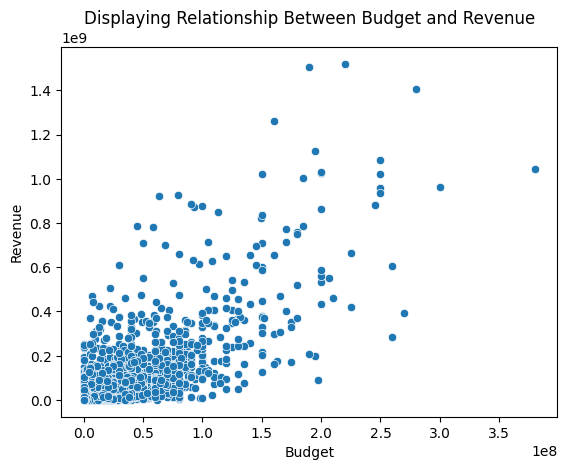

In [13]:
#Association between budget and revenue
sns.scatterplot(x=train['budget'], y=train['revenue'])

# Set titles and labels
plt.title('Displaying Relationship Between Budget and Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')

# Show the plot
plt.show()

This shows that there are many low budget movie that could hamper our analysis. Hence, we are going to remove all low-budget movies, and use a log scale for better visualization.

In [14]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

(array([817.,   5.,   3.,   0.,   3.,   1.,   1.,   1.,   3.,   5.,   5.,
         18.,  30.,  96., 149., 344., 514., 613., 327.,  65.]),
 array([ 0.        ,  0.98778409,  1.97556818,  2.96335227,  3.95113636,
         4.93892045,  5.92670454,  6.91448863,  7.90227273,  8.89005682,
         9.87784091, 10.865625  , 11.85340909, 12.84119318, 13.82897727,
        14.81676136, 15.80454545, 16.79232954, 17.78011363, 18.76789772,
        19.75568181]),
 <BarContainer object of 20 artists>)

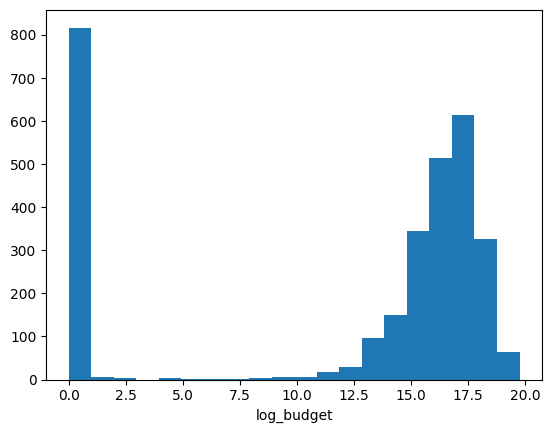

In [15]:
plt.xlabel( 'log_budget')
plt.hist(train['log_budget'],bins = 20)

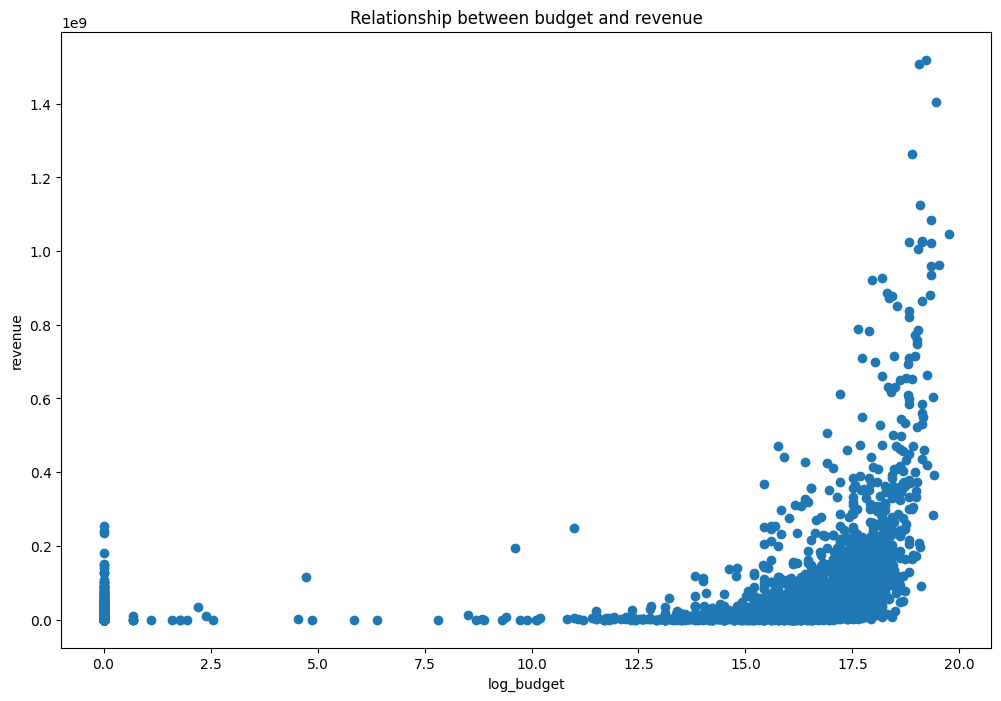

In [16]:
#plot to assess relationship between budget and revenue
plt.figure(figsize=(12, 8)) 
plt.title('Relationship between budget and revenue')
plt.xlabel( 'log_budget')
plt.ylabel('revenue')
plt.scatter(x=train['log_budget'], y=train['revenue'])

In [17]:
def process_genres(df, top_genres=None):
    # Read the dictionary in proper format
    df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Count the number of times each genre appears
    genre_counts = df['genres'].explode().apply(lambda x: x['name'] if isinstance(x, dict) else None).value_counts()

    # If top_genres is None, find the top 5 genres from this DataFrame
    if top_genres is None:
        top_genres = genre_counts.nlargest(5).index.tolist()

    # New columns
    for genre in top_genres:
        df[f'is_genre_{genre}'] = df['genres'].apply(
            lambda genres: 1 if isinstance(genres, list) and any(g['name'] == genre for g in genres) else 0
        )

    return genre_counts  # Return genre counts for plotting

genre_counts_train = process_genres(train)
top_5_genres = genre_counts_train.nlargest(5).index.tolist()
process_genres(test, top_genres=top_5_genres)

train.drop(['genres'], axis=1, inplace=True)
test.drop(['genres'], axis=1, inplace=True)

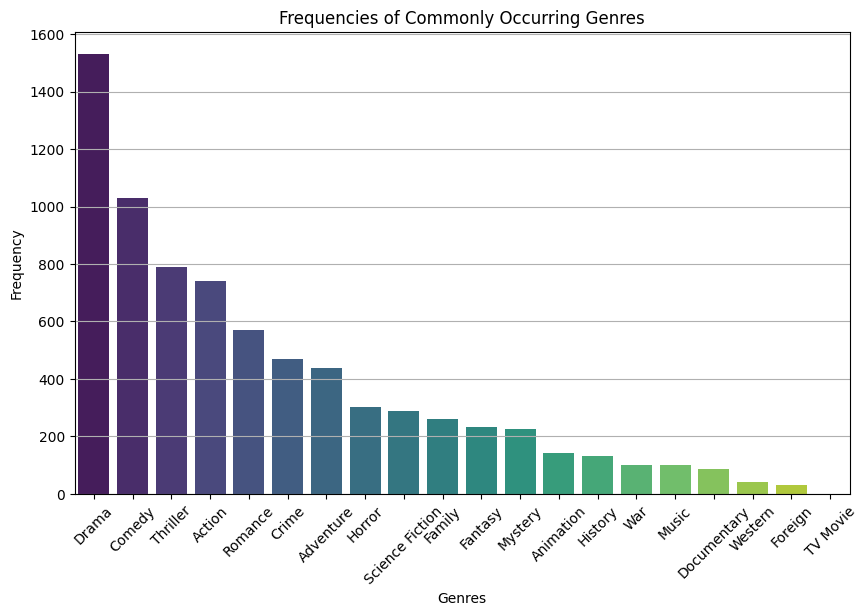

In [18]:
#create plot to show genre counts
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts_train.index, y=genre_counts_train.values, hue =genre_counts_train.index, palette='viridis')
plt.xticks(rotation=45)
plt.title('Frequencies of Commonly Occurring Genres')
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Drama, Comedy, Thriller, Action, Romance are identified as the top 5 most frequently occurring genres.

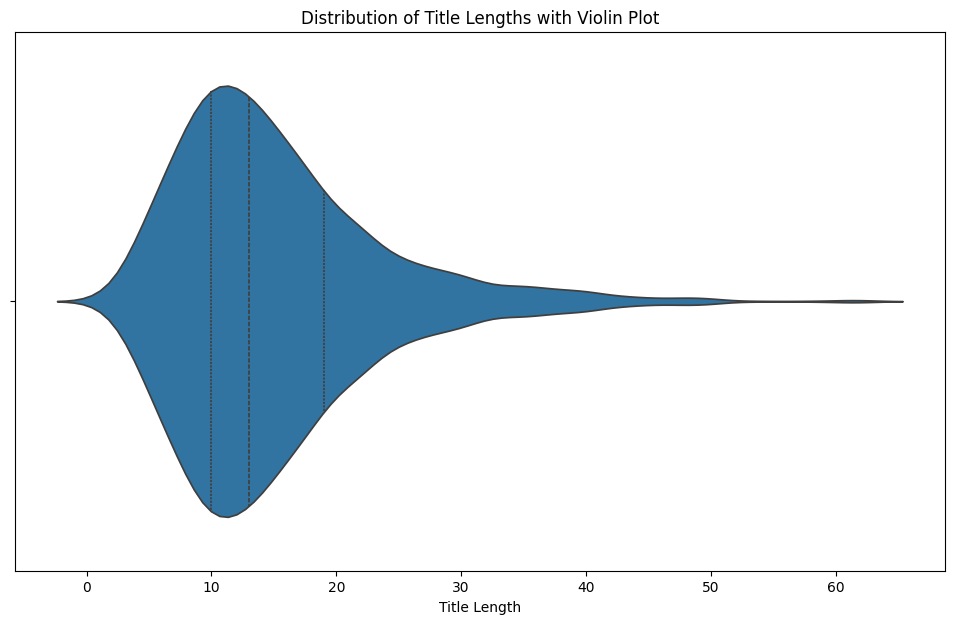

In [19]:

#title length NA handling
train["title"] = train["title"].fillna("")
test["title"] = test["title"].fillna("")

train["title_len"] = train["title"].apply(len)
test["title_len"] = test["title"].apply(len)

plt.figure(figsize=(12, 7))
sns.violinplot(x=train["title_len"], inner="quartile")
plt.title("Distribution of Title Lengths with Violin Plot")
plt.xlabel("Title Length")
plt.show()

train.drop(['title'], axis=1, inplace=True)
test.drop(['title'], axis=1, inplace=True)

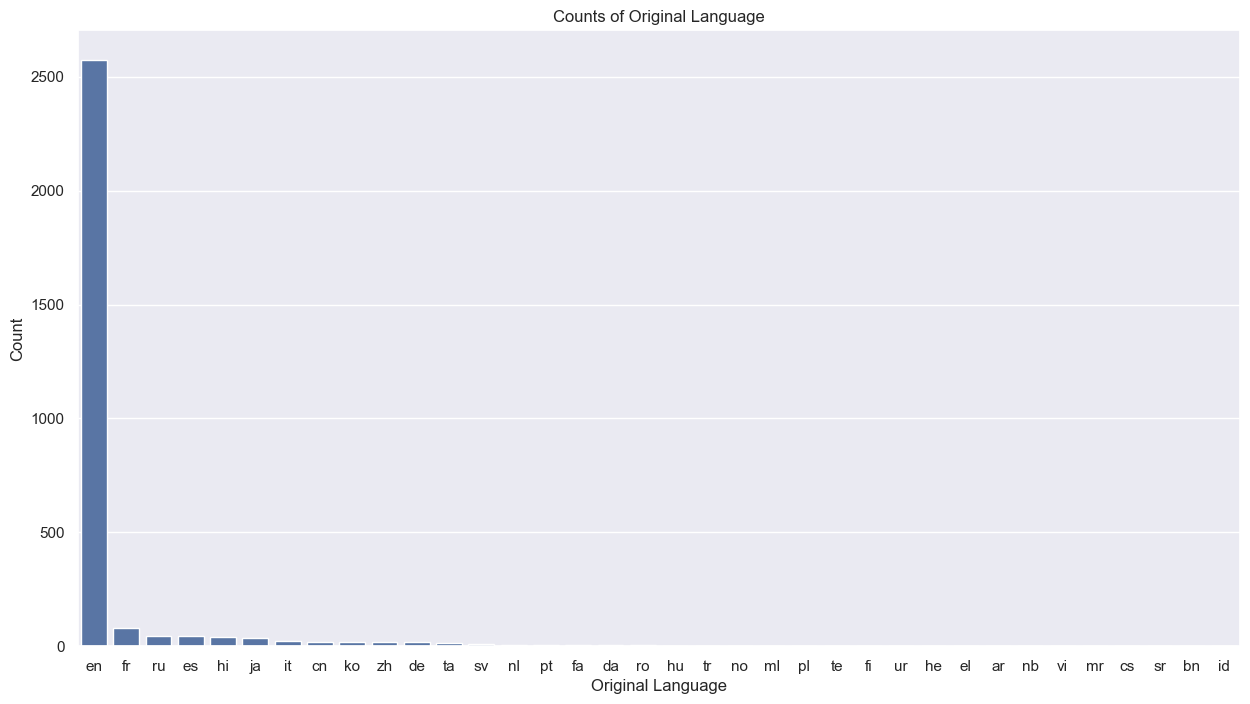

In [20]:
#counting the languages
sns.set(rc={'figure.figsize': (15, 8)})

# Create a count plot for original_language
sns.countplot(x='original_language', data=train, order=train['original_language'].value_counts().index)
plt.title('Counts of Original Language')
plt.xlabel('Original Language')
plt.ylabel('Count')
plt.show()

In [21]:
#feature engineering (if language is english: 1, else 0)
for i in train['original_language']:
    if i == 'en':
        train['Has_En'] = 1
    else:
        train['Has_En'] = 0

for j in test['original_language']:
    if j == 'en':
        test['Has_En'] = 1
    else:
        test['Has_En'] = 0

#drop language data later
train.drop(['original_language'], axis=1, inplace=True)
test.drop(['original_language'], axis=1, inplace=True)

In [22]:
#extract dictionary information for production companies
train['production_companies'] = train['production_companies'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test['production_companies'] = test['production_companies'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

train['production_company_names'] = train['production_companies'].apply(lambda x: [company['name'] for company in x] if isinstance(x, list) else [])
test['production_company_names'] = test['production_companies'].apply(lambda x: [company['name'] for company in x] if isinstance(x, list) else [])

# count occurrences
company_counts = train['production_company_names'].explode().value_counts()

#assign scores based on counts
scores = pd.DataFrame(company_counts).reset_index()
scores.columns = ['production_company', 'count']
scores['score'] = scores['count'].rank(method='min', ascending=False)

#create a mapping of and calculate mean score
score_mapping = scores.set_index('production_company')['score'].to_dict()

train['production_company_score'] = train['production_company_names'].apply(
    lambda companies: np.mean([score_mapping.get(company, 0) for company in companies]) if companies else np.nan
)

test['production_company_score'] = test['production_company_names'].apply(
    lambda companies: np.mean([score_mapping.get(company, 0) for company in companies]) if companies else np.nan
)

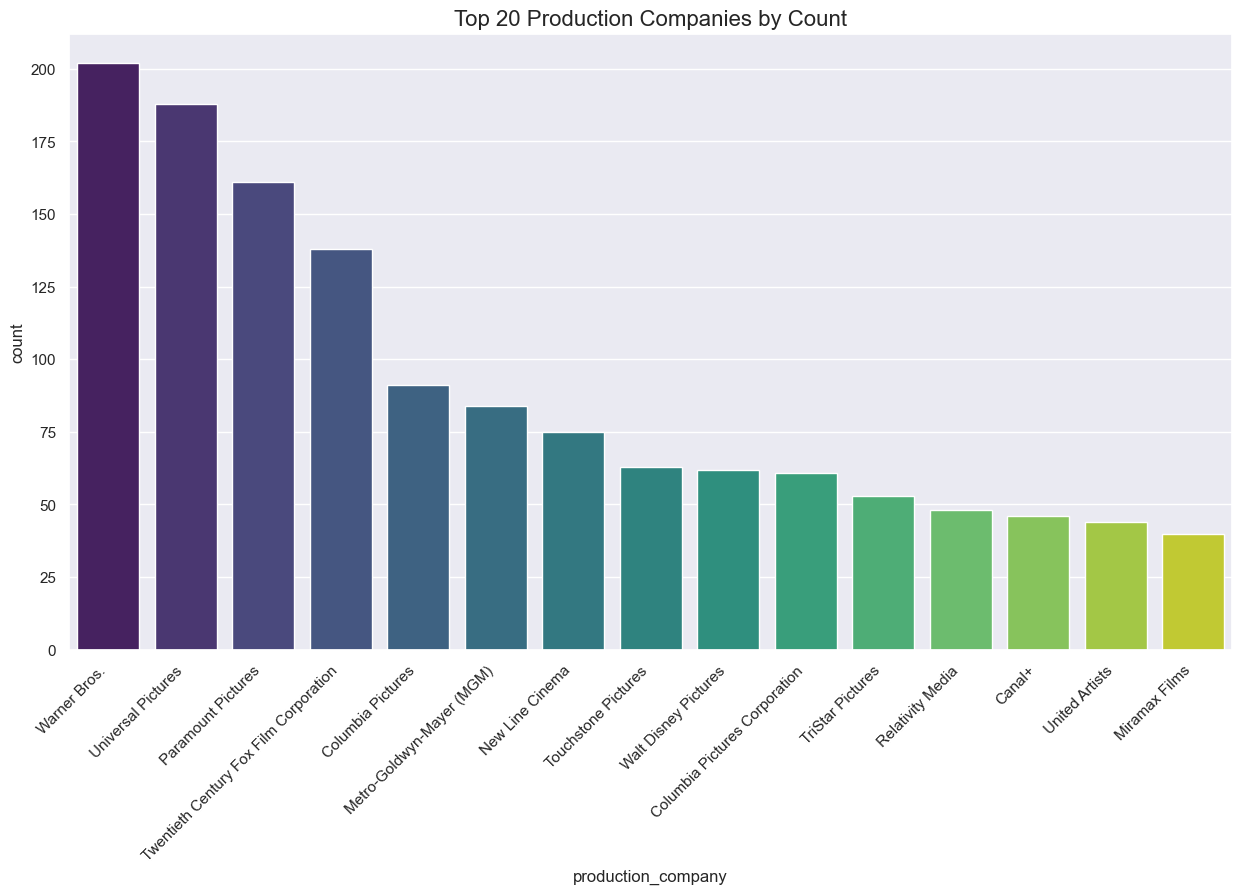

In [23]:
top_15_companies = scores.nlargest(15, 'count')

sns.barplot(x='production_company', y='count', data=top_15_companies, hue='production_company', palette='viridis')

plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Production Companies by Count', fontsize=16)
plt.show()

train.drop(['production_companies', 'production_company_names'], axis=1, inplace=True)
test.drop(['production_companies', 'production_company_names'], axis=1, inplace=True)

In [24]:
#extracting the production country
def extract_production_country(countries):
    try:
        d = ast.literal_eval(countries) 
    except (ValueError, SyntaxError):
        return np.NaN  

    if isinstance(d, list) and len(d) > 0:
        if len(d) > 1:
            country_names = [country['name'] for country in d]
            # Check for 'United States of America'
            if 'United States of America' in country_names:
                return 'United States of America'
            else:
                return country_names[0]  # Return the first country if USA is not present
        else:
            return d[0]['name']  
    return np.NaN  # Return NaN if the list is empty

train['production_country'] = train['production_countries'].apply(extract_production_country)
test['production_country'] = test['production_countries'].apply(extract_production_country)

# Display counts of each production country
train['production_country'].value_counts()

production_country
United States of America    2282
United Kingdom               104
France                        99
India                         75
Russia                        46
Japan                         34
Canada                        33
Italy                         28
China                         26
Spain                         25
Australia                     22
Germany                       21
South Korea                   18
Hong Kong                     18
Belgium                       12
Ireland                       10
Denmark                        9
Mexico                         8
Sweden                         8
Brazil                         7
Austria                        5
New Zealand                    5
Finland                        4
Netherlands                    4
Czech Republic                 4
Iran                           4
Hungary                        3
Norway                         3
Romania                        3
Philippines             

In [25]:
#since most movies were produced in the US, we again do feature engineering
train['prod_is_US'] = np.where(train['production_country'] == 'United States of America', 1,
                                    np.where(train['production_country'].isna(), np.NaN, 0))

test['prod_is_US'] = np.where(test['production_country'] == 'United States of America', 1,
                                   np.where(test['production_country'].isna(), np.NaN, 0))

train.drop(['production_countries', 'production_country'], axis=1, inplace=True)
test.drop(['production_countries', 'production_country'], axis=1, inplace=True)

In [26]:
print(train['runtime'].isnull().sum())

#mean imputation of runtime - if runtime is missing, it is replaced my the mean of runtime
train['runtime']=train['runtime'].fillna(train['runtime'].mean()).round()
test['runtime']=test['runtime'].fillna(test['runtime'].mean()).round()  

2


<Axes: xlabel='runtime', ylabel='revenue'>

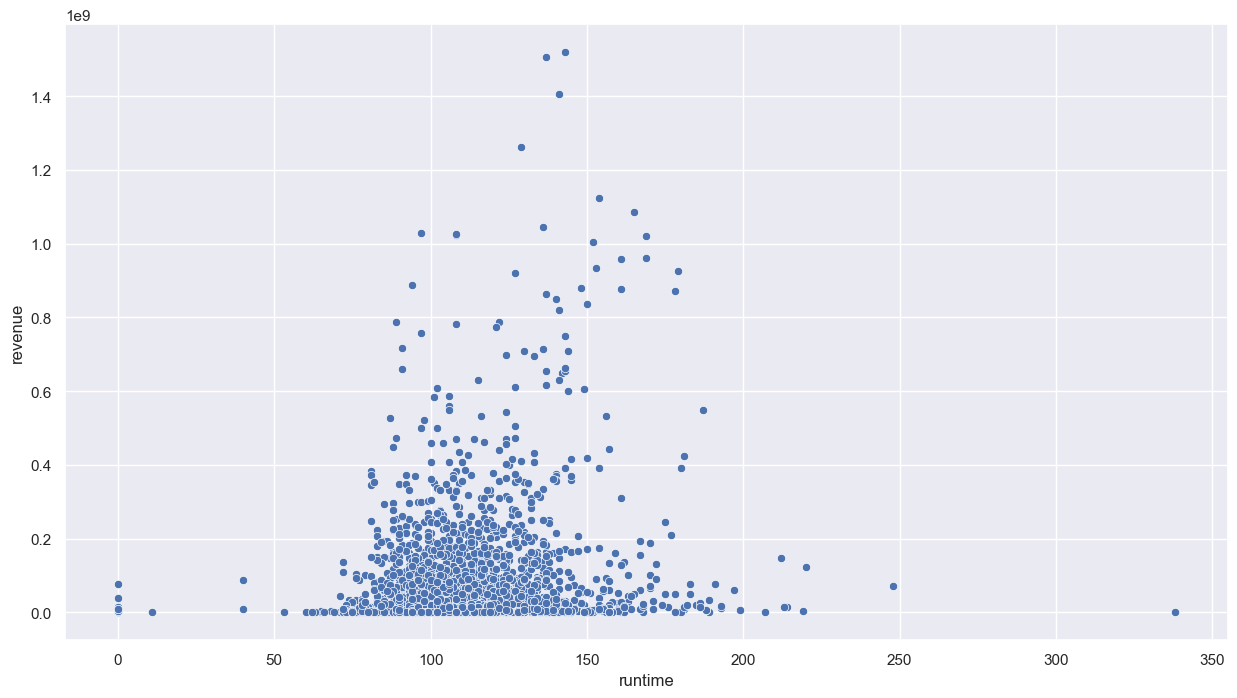

In [27]:
#do longer movies make more money? this scatterplot assesses this
sns.scatterplot(x='runtime', y='revenue', data=train)

In [28]:
#surely release timing has an effect
train['release_date'] = pd.to_datetime(train['release_date'], errors='coerce', format='%m/%d/%y')

train['release_year'] = train['release_date'].dt.year
train['release_month'] = train['release_date'].dt.month
train['release_week'] = train['release_date'].dt.isocalendar().week  

#do the same for test
test['release_date'] = pd.to_datetime(test['release_date'], errors='coerce', format='%m/%d/%y')

test['release_year'] = test['release_date'].dt.year
test['release_month'] = test['release_date'].dt.month
test['release_week'] = test['release_date'].dt.isocalendar().week  

#invalid year data
print("Movies with invalid years:", len(train[train['release_year'] > 2024]))

#set them as NaN
train.loc[train['release_year'] > 2024, 'release_year'] = np.NaN
test.loc[test['release_year'] > 2024, 'release_year'] = np.NaN

train.drop(['release_date'], axis=1, inplace=True)
test.drop(['release_date'], axis=1, inplace=True)

Movies with invalid years: 144


In [29]:
#extract dictionary information for the cast
train['cast'] = train['cast'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test['cast'] = test['cast'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#maintain num_cast columnv - counts the number of people in the cast of a movie
train['num_cast'] = train['cast'].apply(lambda x: len(x) if isinstance(x, list) else 0)
test['num_cast'] = test['cast'].apply(lambda x: len(x) if isinstance(x, list) else 0)

#drop the existing cast column
train.drop('cast', axis=1, inplace=True)
test.drop('cast', axis=1, inplace=True)


In [30]:
def process_crew(df):
    #extract dictionary information for the crew
    df['crew'] = df['crew'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    #maintain num_crew count - counts the number of crew members per movie
    df['num_crew'] = df['crew'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    
    #drop the 'crew' column
    df.drop('crew', axis=1, inplace=True)

process_crew(train)
process_crew(test)

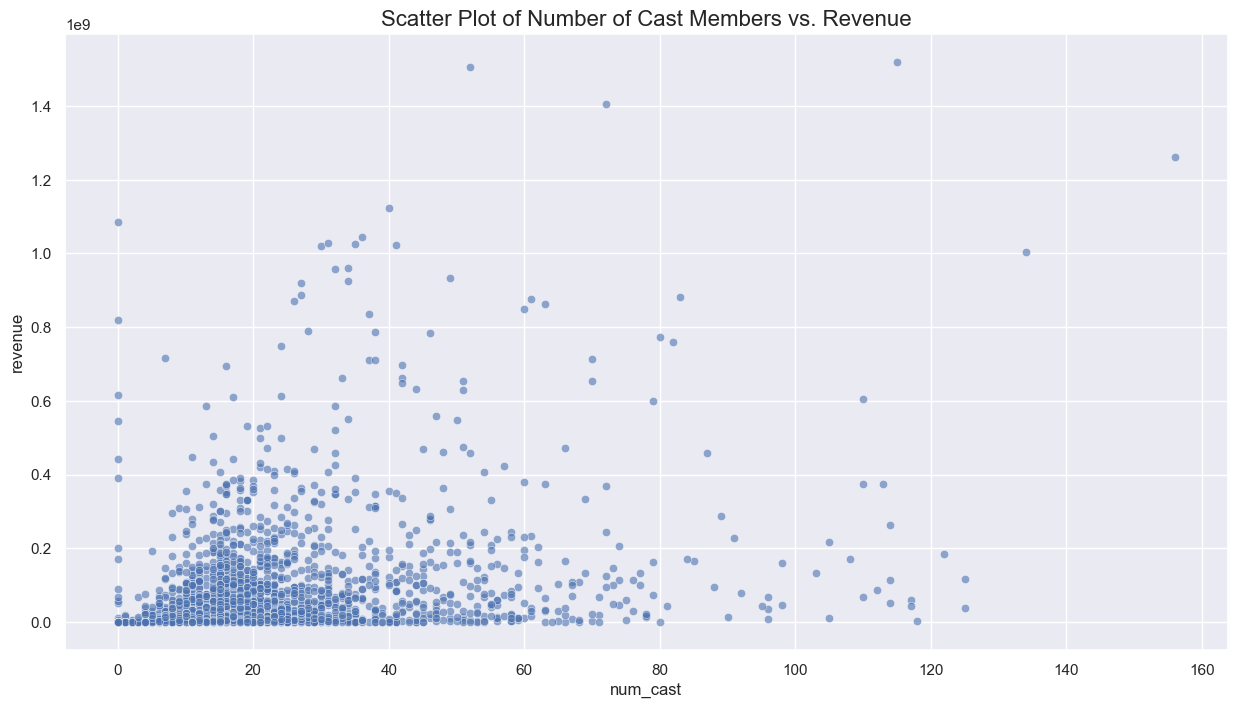

In [31]:
sns.scatterplot(x='num_cast', y='revenue', data=train, alpha=0.6)
plt.title('Scatter Plot of Number of Cast Members vs. Revenue', fontsize=16)
plt.show()

In [32]:
#check structure of data after cleaning
train.head()

,id,budget,popularity,runtime,revenue,popularity2,rating,totalVotes,has_homepage,has_overview,...,is_genre_Romance,title_len,Has_En,production_company_score,prod_is_US,release_year,release_month,release_week,num_cast,num_crew
0,1,14000000,6.575393,93.0,12314651,10.400,5.0,482.0,0,1,...,0,22,1,7.666667,1.0,2015.0,2,8,24,72
1,2,40000000,8.248895,113.0,95149435,15.229,6.4,1528.0,0,1,...,1,40,1,9.000000,1.0,2004.0,8,32,20,9
2,3,3300000,64.299990,105.0,13092000,26.082,8.4,7314.0,1,1,...,0,8,1,171.333333,1.0,2014.0,10,41,51,64
3,4,1200000,3.174936,122.0,16000000,5.531,7.5,115.0,1,1,...,0,7,1,NaN,0.0,2012.0,3,10,7,3
4,5,0,1.148070,118.0,3923970,NaN,NaN,NaN,0,1,...,0,10,1,NaN,0.0,2009.0,2,6,4,2


In [33]:
#ensure test matches train
test.head()

,id,budget,popularity,runtime,popularity2,rating,totalVotes,has_homepage,has_overview,log_budget,...,is_genre_Romance,title_len,Has_En,production_company_score,prod_is_US,release_year,release_month,release_week,num_cast,num_crew
0,3001,0,3.851534,90.0,6.468,6.6,91.0,1,1,0.000000,...,0,28,0,NaN,1.0,2007.0,7.0,28,7,2
1,3002,88000,3.559789,65.0,3.649,4.5,51.0,0,1,11.385103,...,0,27,0,0.000000,1.0,NaN,5.0,20,10,8
2,3003,0,8.085194,100.0,9.012,6.1,176.0,0,1,0.000000,...,1,16,0,203.333333,1.0,1997.0,5.0,21,9,10
3,3004,6800000,8.596012,130.0,10.923,8.0,937.0,1,1,15.732433,...,0,9,0,346.000000,0.0,NaN,NaN,<NA>,23,69
4,3005,2000000,3.217680,92.0,5.692,6.8,50.0,0,1,14.508658,...,0,18,0,NaN,1.0,NaN,NaN,<NA>,4,14


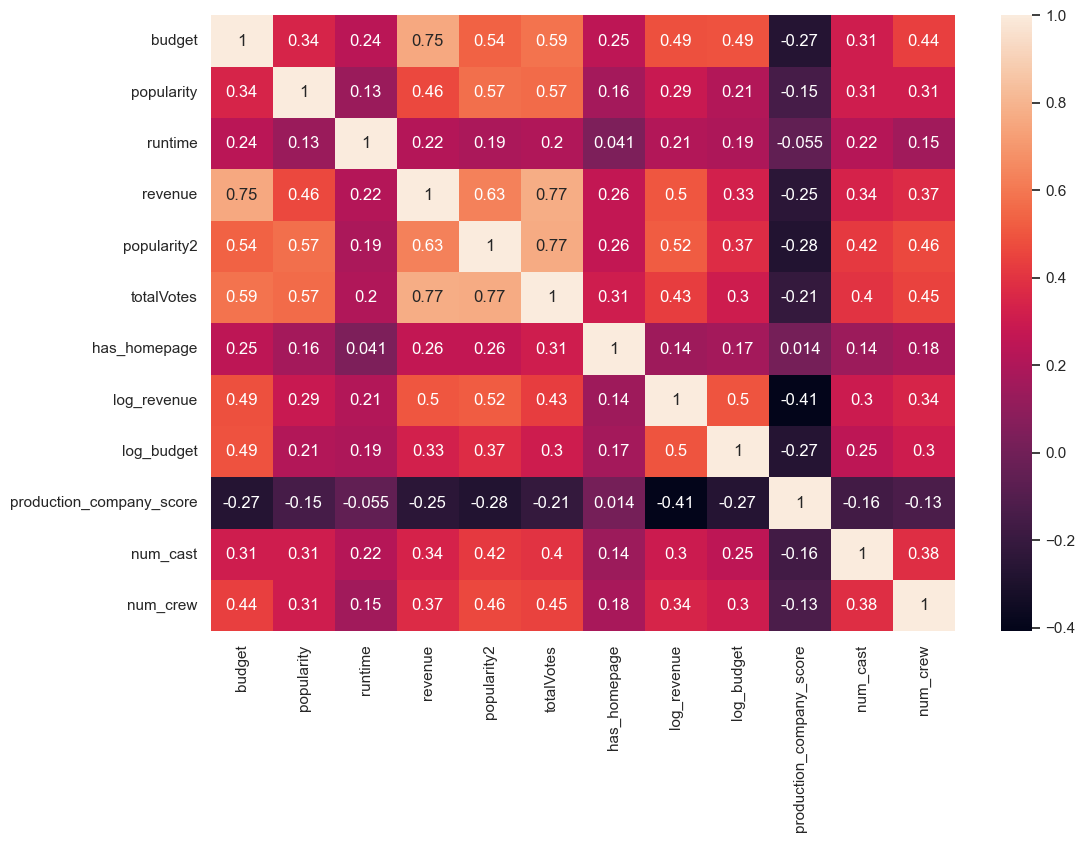

In [34]:
#Correlation plot

corr =train.corr()
top_feature = corr.index[abs(corr['revenue'])>0.2]

plt.subplots(figsize=(12, 8))
top_corr = train[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

Through this chart, we can see that budget, popularity, cast size, crew size, and popularity of production company is correlated with the revenue.

#### Model Application and Fine Tuning

In [35]:
#incorrect data according to https://www.kaggle.com/code/kamalchhirang/eda-feature-engineering-lgb-xgb-cat#Feature-Engineering-&-Prediction
#has been cleaned accordingly
 
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1007,'budget'] = 2              # Zyzzyx Road 
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 1885,'budget'] = 12             # In the Cut
train.loc[train['id'] == 2091,'budget'] = 10             # Deadfall
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'budget'] = 6              # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9               # Death at a Funeral
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000

#Clean Data
test.loc[test['id'] == 6733,'budget'] = 5000000
test.loc[test['id'] == 3889,'budget'] = 15000000
test.loc[test['id'] == 6683,'budget'] = 50000000
test.loc[test['id'] == 5704,'budget'] = 4300000
test.loc[test['id'] == 6109,'budget'] = 281756
test.loc[test['id'] == 7242,'budget'] = 10000000
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30

In [36]:
train['rating'] = train['rating'].fillna(1.5)
train['totalVotes'] = train['totalVotes'].fillna(6)

test['rating'] = test['rating'].fillna(1.5)
test['totalVotes'] = test['totalVotes'].fillna(6)

In [37]:
#year_adjusted budget (inflation adjustion)
train['budget_year_ratio'] = np.round(train['budget']/(train['release_year']*train['release_year']), 2)
test['budget_year_ratio'] = np.round(test['budget']/(test['release_year']*test['release_year']), 2)

#other ratios
train['releaseYear_popularity_ratio'] = np.round(train['release_year']/train['popularity'], 2)
test['releaseYear_popularity_ratio'] = np.round(test['release_year']/test['popularity'], 2)

train['popularity_mean_year'] = train['popularity'] / train.groupby("release_year")["popularity"].transform('mean')
test['popularity_mean_year'] = test['popularity'] / test.groupby("release_year")["popularity"].transform('mean')

train['budget_runtime_ratio'] = train['budget']/train['runtime'] 
test['budget_runtime_ratio'] = test['budget']/test['runtime'] 

In [38]:
train.columns

Index(['id', 'budget', 'popularity', 'runtime', 'revenue', 'popularity2',
       'rating', 'totalVotes', 'has_homepage', 'has_overview', 'log_revenue',
       'log_budget', 'is_genre_Drama', 'is_genre_Comedy', 'is_genre_Thriller',
       'is_genre_Action', 'is_genre_Romance', 'title_len', 'Has_En',
       'production_company_score', 'prod_is_US', 'release_year',
       'release_month', 'release_week', 'num_cast', 'num_crew',
       'budget_year_ratio', 'releaseYear_popularity_ratio',
       'popularity_mean_year', 'budget_runtime_ratio'],
      dtype='object')

In [39]:
test.columns

Index(['id', 'budget', 'popularity', 'runtime', 'popularity2', 'rating',
       'totalVotes', 'has_homepage', 'has_overview', 'log_budget',
       'is_genre_Drama', 'is_genre_Comedy', 'is_genre_Thriller',
       'is_genre_Action', 'is_genre_Romance', 'title_len', 'Has_En',
       'production_company_score', 'prod_is_US', 'release_year',
       'release_month', 'release_week', 'num_cast', 'num_crew',
       'budget_year_ratio', 'releaseYear_popularity_ratio',
       'popularity_mean_year', 'budget_runtime_ratio'],
      dtype='object')

## Applying the ML Algorithms

In [40]:
features = [
    'budget', 'popularity', 'runtime', 'popularity2', 'rating',
    'totalVotes', 'has_homepage', 'has_overview', 'log_budget',
    'is_genre_Drama', 'is_genre_Comedy', 'is_genre_Thriller',
    'is_genre_Action', 'is_genre_Romance', 'title_len', 'Has_En',
    'production_company_score', 'prod_is_US', 'release_year',
    'release_month', 'release_week', 'num_cast', 'num_crew',
    'budget_year_ratio', 'releaseYear_popularity_ratio', 'popularity_mean_year'
]

X_train = train[features]
y_train = train['log_revenue']
X_test = test[features]

#### K-Fold Cross Validation

In [41]:
# Function to train and predict using a given model
def train_and_predict(model, X_train, y_train, X_test):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    predictions = cross_val_predict(model, X_train, y_train, cv=kf, method='predict')
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    return predictions, test_predictions


#### Random Forest Regressor - Kaggle RMSE (2.07821)

In [42]:
rf_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Setup the RandomizedSearchCV
rf_random_search = RandomizedSearchCV(estimator=rf_model,
                                       param_distributions=param_grid,
                                       n_iter=100,
                                       cv=5,
                                       verbose=2,
                                       random_state=42,
                                       n_jobs=-1)

# Fit the Randomized Search
rf_random_search.fit(X_train, y_train)

# Best parameters and score
best_params = rf_random_search.best_params_
best_score = rf_random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validated Score: {best_score}")

# Use the best estimator to make predictions
best_rf_model = rf_random_search.best_estimator_
rf_test_predictions = best_rf_model.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7

#### XGBoost Regressor - Kaggle RMSE (2.15581)

In [43]:
# XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_predictions, xgb_test_predictions = train_and_predict(xgb_model, X_train, y_train, X_test)
xgb_rmse = mean_squared_error(y_train, xgb_predictions)

print(f"XGBoost RMSE: {xgb_rmse}")


XGBoost RMSE: 4.078646464094529


In [45]:
# Create submission files
rf_submission = pd.DataFrame({
    'id': test['id'],
    'revenue': np.exp(rf_test_predictions) 
})

xgb_submission = pd.DataFrame({
    'id': test['id'],
    'revenue': np.exp(xgb_test_predictions)  
})

'''bagging_submission = pd.DataFrame({
    'id': test['id'],
    'revenue': np.exp(bagging_test_predictions)  
})'''

rf_submission.to_csv('rf_submission.csv', index=False)
xgb_submission.to_csv('xgb_submission.csv', index=False)